In [1]:
import pandas as pd
from datetime import datetime
from zoe import cases, query, pickle, find_previous, plot_study, plot_study_evolution

In [2]:
uk_active_cases = query("SELECT * FROM uk_active_cases", index='date')
uk_active_cases.index = pd.to_datetime(uk_active_cases.index, format='%Y%m%d')
uk_active_cases

,cartodb_id,the_geom,the_geom_webmercator,corrected_covid_positive
date,,,,
2020-06-12,57982,None,None,86085.715275
2020-06-13,57983,None,None,79940.811469
2020-06-14,57984,None,None,74244.112992
2020-06-15,57985,None,None,68878.187593
2020-06-16,57986,None,None,64137.552455
...,...,...,...,...
2021-05-13,58317,None,None,30554.080543
2021-05-14,58318,None,None,31231.855769
2021-05-15,58319,None,None,31767.754912


In [3]:
curr_date = uk_active_cases.index.max()
print(pickle(uk_active_cases, 'uk_active_cases', curr_date))

/Users/chris/coronavirus/data/zoe_uk_active_cases_2021-05-17_2021-05-17-16-54.pickle


In [4]:
prev_date, prev_uk_active_cases = find_previous(curr_date)

/Users/chris/coronavirus/data/zoe_uk_active_cases_2021-05-16_2021-05-16-16-55.pickle


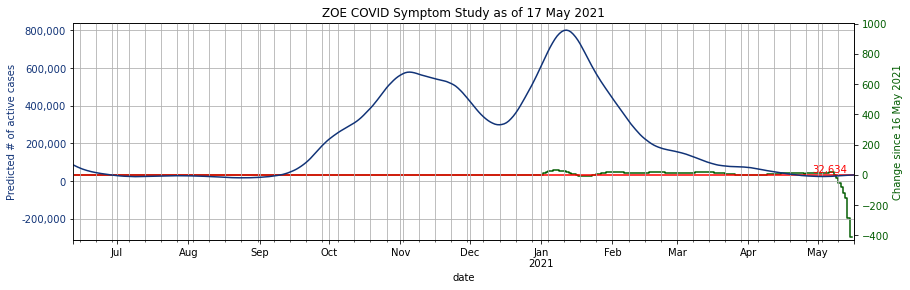

In [5]:
plot_study(curr_date, prev_date, uk_active_cases, prev_uk_active_cases)

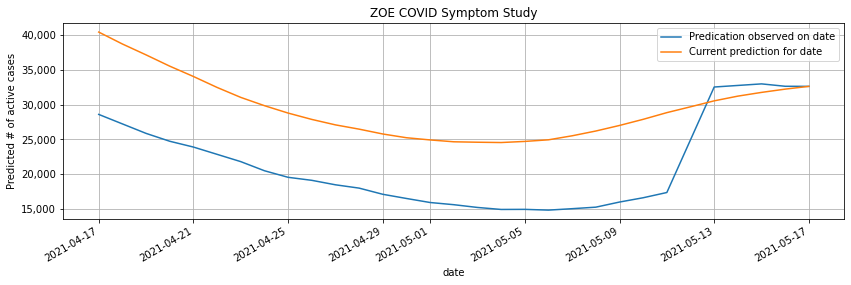

In [6]:
plot_study_evolution(curr_date, days=30)

In [7]:
prevalence_map = query("SELECT * FROM prevalence_map")
prevalence_map['percentage'] = prevalence_map['percentage'].astype(float)

In [8]:
for_date, = prevalence_map['data_status'].unique()
print(pickle(prevalence_map, 'prevalence_map', datetime.strptime(for_date, '%H:%M:%S %d-%m-%Y')))

/Users/chris/coronavirus/data/zoe_prevalence_map_2021-05-17_2021-05-17-16-54.pickle


In [9]:
prevalence_map[['lad16nm', 'lad16cd', 'percentage']].sort_values('percentage', ascending=False)[:10]

,lad16nm,lad16cd,percentage
386,Newport,W06000022,0.561914
302,Kirklees,E08000034,0.360609
239,Leeds,E08000035,0.357276
324,East Dunbartonshire,S12000045,0.356575
298,Fife,S12000015,0.237435
376,South Lanarkshire,S12000029,0.233706
299,Wolverhampton,E08000031,0.231208
106,High Peak,E07000037,0.227288
156,Broadland,E07000144,0.192184
42,Bedford,E06000055,0.180171
